# Text classification of emails

In [ ]:

!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 103.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.14.1
  Attempting uninstall: tensorflow
    Found existing insta

In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv('spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Data Preprocessing

In [ ]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

1)we will be downsampling ham to obtain balance number of counts
2)convert category to numerical values

In [ ]:
df_spam=df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [ ]:
df_ham=df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [ ]:
df_ham_downsampled=df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [ ]:
df_balanced=pd.concat([df_spam,df_ham_downsampled])
df_balanced.shape

(1494, 2)

In [ ]:
df_balanced.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham          747    735                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham         4  
spam        4

In [ ]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x:1 if x=='spam' else 0)


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_Test,y_train,y_test=train_test_split(df_balanced['Message'],df_balanced['spam'],stratify=df_balanced['spam'])

In [ ]:
X_train.sample(4)

740     Haha mayb u're rite... U know me well. Da feel...
719     You have WON a guaranteed £1000 cash or a £200...
4166    Dear Voucher Holder, To claim this weeks offer...
833     Dear Voucher Holder, To claim this weeks offer...
Name: Message, dtype: object

Sentence vectorization

In [ ]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3')

In [ ]:
def get_sentence_embedding(sentences):
  preprocessed_text=bert_preprocess(sentences,)
  return bert_encoder(preprocessed_text)['pooled_output']

e=get_sentence_embedding(["500$ discount,hurry up!","We have to reach by tomorrow."
])

Model initialization

In [ ]:
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)

l1=tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])

l2=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l1)

model=tf.keras.Model(inputs=[text_input],outputs=[l2])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer_2 (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [ ]:
Metrics=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=Metrics)


Model training

In [ ]:
model.fit(X_train,y_train,epochs=5)

Epoch 1/5
35/35 [==============================] - 521s 15s/step - loss: 0.6203 - accuracy: 0.6705 - precision: 0.6792 - recall: 0.6464
Epoch 2/5
35/35 [==============================] - 522s 15s/step - loss: 0.5189 - accuracy: 0.8125 - precision: 0.7956 - recall: 0.8411
Epoch 3/5
35/35 [==============================] - 530s 15s/step - loss: 0.4594 - accuracy: 0.8384 - precision: 0.8273 - recall: 0.8554
Epoch 4/5
35/35 [==============================] - 521s 15s/step - loss: 0.4210 - accuracy: 0.8571 - precision: 0.8497 - recall: 0.8679
Epoch 5/5
35/35 [==============================] - 539s 15s/step - loss: 0.3838 - accuracy: 0.8741 - precision: 0.8486 - recall: 0.9107


In [ ]:
model.evaluate(X_Test, y_test)

12/12 [==============================] - 179s 15s/step - loss: 0.3610 - accuracy: 0.8930 - precision: 0.9349 - recall: 0.8449


[0.36100801825523376,
 0.893048107624054,
 0.9349112510681152,
 0.8449198007583618]

In [ ]:
y_predicted = model.predict(X_Test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 177s 15s/step


In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[176,  11],
       [ 29, 158]])

Text(50.722222222222214, 0.5, 'Truth')

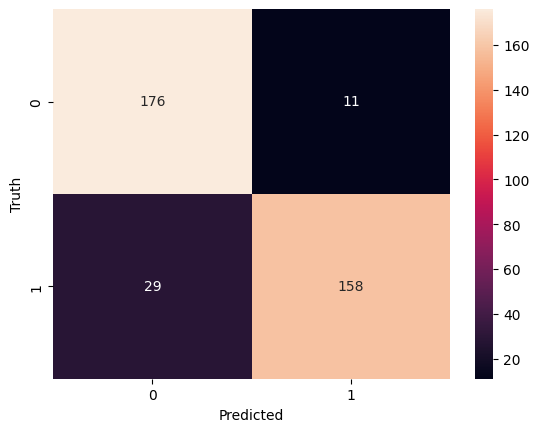

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

Inference

In [ ]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 5s 5s/step


array([[0.5564156 ],
       [0.606404  ],
       [0.6185976 ],
       [0.20963065],
       [0.15905292]], dtype=float32)